In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm
from pyts.decomposition import SingularSpectrumAnalysis
from torch.distributions.multivariate_normal import MultivariateNormal

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [56]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values

data = np.log1p(data)

In [3]:
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [4]:
def calc_windows_eq_size(data, size=10):
    k = len(data)//size
    windows = []

    for i in range(size):
        windows.append(data[i*k : (i+1)*k])
        
    windows = np.mean(np.array(windows), 1)
    
    return torch.FloatTensor(windows)

# dataloader = DataLoader(windows.reshape(-1, 20, 1), batch_size=20, shuffle=True)

In [68]:
calc_windows_eq_size(data, size=10)

tensor([2.7218, 2.4852, 2.1103, 2.1354, 1.8761, 1.9799, 1.8322, 2.0872, 1.3015,
        1.1722])

In [5]:
groups = [np.arange(i, i + 5) for i in range(0, 20, 4)]
ssa = SingularSpectrumAnalysis(window_size=100, groups=groups)
X_ssa = ssa.fit_transform(data.reshape(1, -1))

In [6]:
X_ssa[0].T

array([[ 2.81538383e+00,  1.18522116e-02, -8.15404029e-03,
         1.51716365e-02, -8.19227519e-03],
       [ 2.81436861e+00,  1.21949862e-02, -1.05589758e-02,
         1.48903956e-02, -5.36445647e-03],
       [ 2.81280110e+00,  1.22107012e-02, -1.25864889e-02,
         1.16650486e-02, -2.01124847e-03],
       ...,
       [ 6.65785177e-01, -1.96548400e-02, -6.90585277e-03,
         3.82663012e-03, -4.35128503e-03],
       [ 6.63369752e-01, -1.77631392e-02, -3.48208143e-03,
         7.19890065e-03, -5.23019054e-03],
       [ 6.61521755e-01, -1.53103729e-02,  1.21407235e-03,
         1.00563829e-02, -4.11996050e-03]])

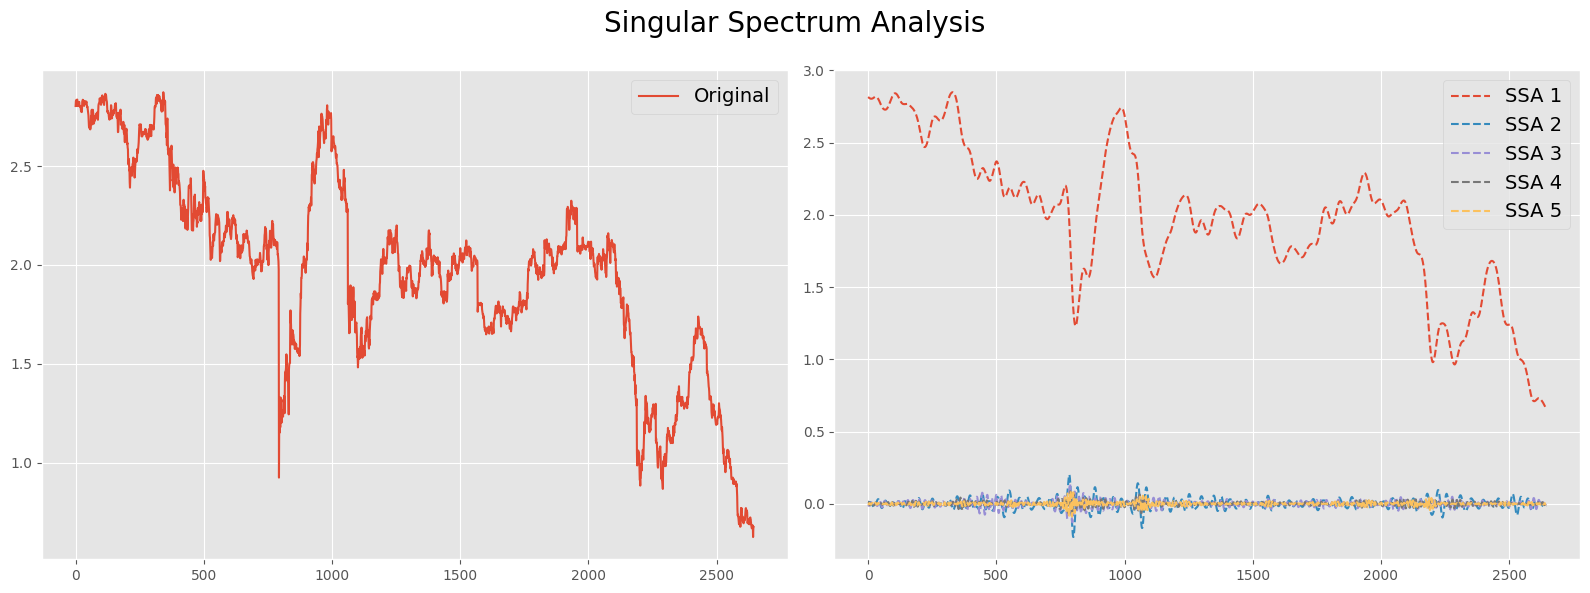

In [7]:
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.plot(data, label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)
for i in range(len(groups)):
    ax2.plot(X_ssa[0, i], '--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.show()

In [201]:
def autocorr(x):
    var = x.var()
    mean = x.mean()
    x = x - mean

    result = np.correlate(x, x, mode='full')
    return list(result[len(result)//2:]/var/len(x))

def autocorr_tensor(x, batch_size, seq_len, feature_dim):
    t2 = pd.DataFrame(x.squeeze(2)).apply(lambda x: autocorr(x), axis=1).to_list()
    return torch.FloatTensor(np.array(t2).reshape(batch_size, seq_len, feature_dim))

def spectral_density(x):
    stationarized = pd.Series(x).diff()[1:].diff()[1:].values
    a1 = autocorr(stationarized)
    sd_f = np.fft.fftshift(np.fft.fft(a1))
    # mean_asd = np.mean(np.abs(sd_f)**2)
    
    return np.abs(sd_f)


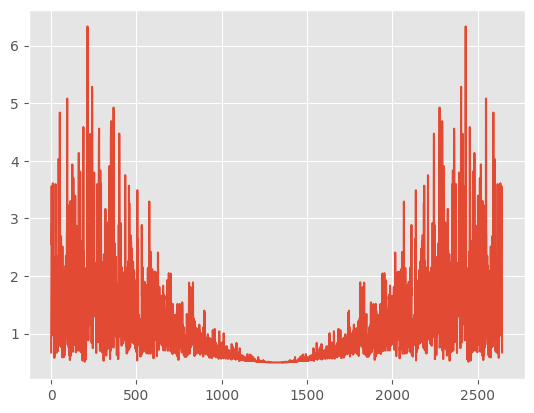

In [202]:
# plt.hist(spectral_density(data), bins=40)
plt.plot(spectral_density(data))

plt.show()

In [203]:
fourier = np.real(np.fft.fftshift(np.fft.fft(data)))
fourier = (fourier - fourier.mean()) / fourier.std()

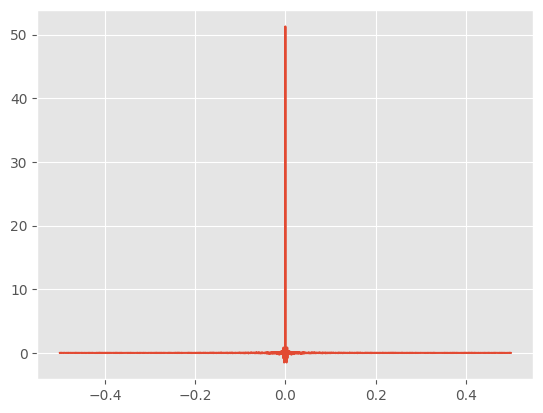

In [204]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(len(data))), fourier)

plt.show()

In [8]:
p_Z = MultivariateNormal(torch.zeros(10), torch.eye(10))
z = p_Z.rsample(sample_shape=(5000,))

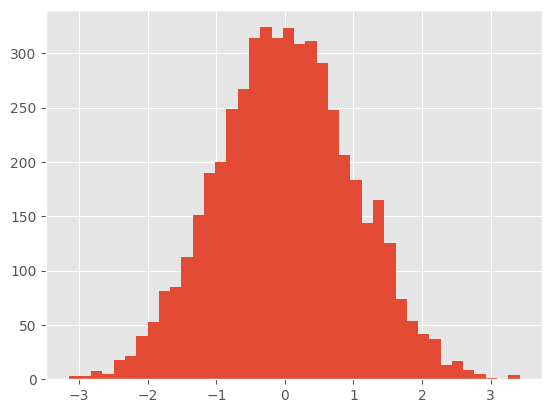

In [9]:
plt.hist(z[:, 0], bins=40)

plt.show()

In [10]:
base_dist = MultivariateNormal(torch.zeros(10), torch.eye(10))

In [11]:
log_pz = base_dist.log_prob(z)

In [14]:
log_pz

tensor([-16.5284, -12.6127, -11.6830,  ..., -16.0155, -14.4955, -16.9214])

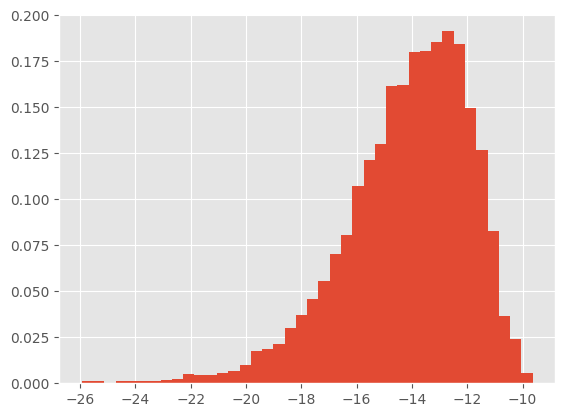

In [15]:
plt.hist(log_pz, bins=40, density=True)

plt.show()

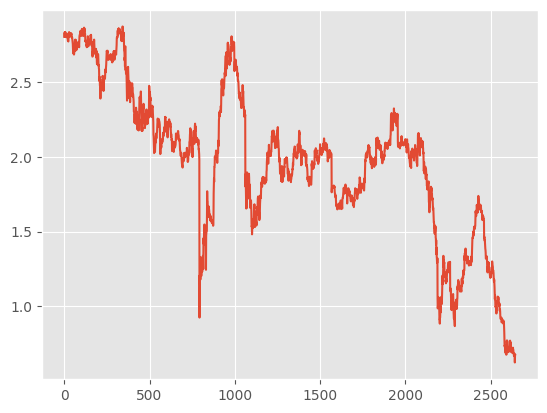

In [17]:
plt.plot(data)
plt.show()

In [25]:
jumps = np.abs(data[:-1] - data[1:])

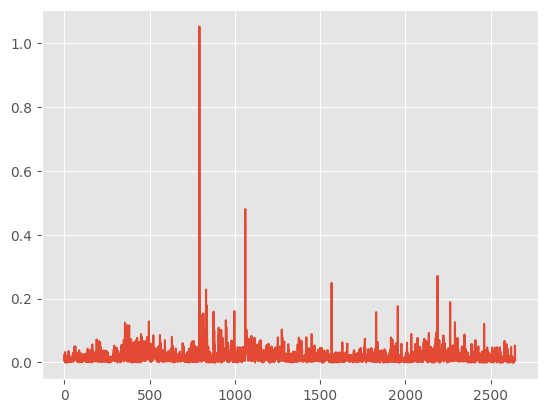

In [27]:
plt.plot(jumps)
plt.show()

In [114]:
idx_jumps = np.where(jumps > 0.15)[0]

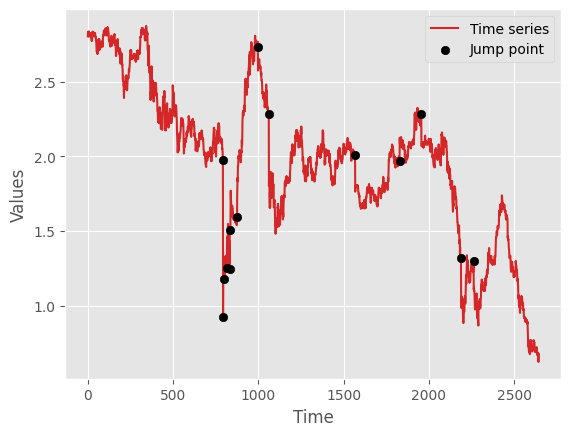

In [118]:
plt.plot(data, color='tab:red', label='Time series')
plt.scatter(idx_jumps, data[idx_jumps], color='black', zorder=2, label='Jump point')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

In [55]:
len(idx_jumps)/len(data)

0.010964083175803403

In [66]:
import itertools

def compute_path_signature(X, a=0, b=1, level_threshold=3):
    N = len(X)
    t = np.linspace(a, b, len(X[0]))
    dt = t[1] - t[0]
    X_t = [Xi for Xi in X]
    t = t[:-1]
    dX_t = [np.diff(Xi_t) for Xi_t in X_t]
    X_prime_t = [dXi_t / dt for dXi_t in dX_t]
    
    signature = [[np.ones(len(t))]]
    for k in range(level_threshold):
        previous_level = signature[-1]
        current_level = []
        for previous_level_integral in previous_level:
            for i in range(N):
                current_level.append(np.cumsum(previous_level_integral * dX_t[i]))
        signature.append(current_level)

    signature_terms = [list(itertools.product(*([np.arange(1, N+1).tolist()] * i)))
                       for i in range(0, level_threshold+1)]
    
    return t, X_t, X_prime_t, signature, signature_terms

In [99]:
t, X_t, X_prime_t, signature, signature_terms = compute_path_signature([data], level_threshold=10)

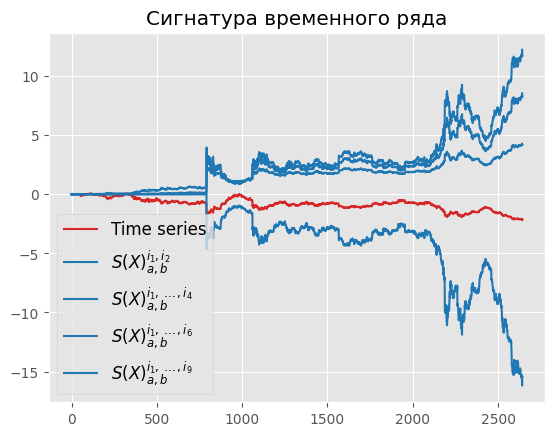

In [113]:
plt.plot(signature[1][0], color='tab:red', label='Time series')
plt.plot(signature[2][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
plt.plot(signature[4][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_4}$')
plt.plot(signature[6][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_6}$')
plt.plot(signature[9][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_9}$')

plt.legend(fontsize=12, loc=3)
plt.title('Сигнатура временного ряда')
plt.show()